In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
# trial data
data = np.load('sample_photostim_0113.npy', allow_pickle = True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session'][10:,:]
u_session = data['u_session'][10:,:]

# y_sub = np.zeros((int(y_session.shape[0]/7),y_session.shape[1]))
# u_sub = np.zeros((int(y_session.shape[0]/7),y_session.shape[1]))
# print(y_session[1000:1050,1])
# for i in range(int(y_session.shape[0]/7)):
#     if np.mod(i,2) == 0:
#         y_sub[i,:] = np.mean(y_session[i*7:i*7+4,:], axis=0)
#         u_sub[i,:] = np.mean(u_session[i*7+4:i*7+7,:], axis=0)
#         #print(y_session[i*7:i*7+4,0])
#     else:
#         y_sub[i,:] = np.mean(y_session[i*7:i*7+7,:], axis=0)
#         u_sub[i,:] = np.mean(u_session[i*7:i*7+7,:], axis=0)
        

idx = 0
y_sub = []
u_sub = []
while True:
    for i in range(100):
        if np.isnan(y_session[idx+i,0]):
            break
    y_sub.append(np.mean(y_session[idx:idx+int(i/2),:],axis=0))
    y_sub.append(np.mean(y_session[idx+int(i/2):idx+i,:],axis=0))
    u_sub.append(np.mean(u_session[idx:idx+int(i/2),:],axis=0))
    u_sub.append(np.mean(u_session[idx+int(i/2):idx+i+3,:],axis=0) > 0)
    for j in range(100):
        if not np.isnan(y_session[idx+i+j,0]):
            idx = idx + i + j
            break
    if idx > 33600:
        break
  
y_sub = np.array(y_sub)
u_sub = np.array(u_sub)
            
# i = 3
# print(y_session[i*7:i*7+5,0])
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(u_session[:,0])
# #plt.plot(y_sub[:,0])
# plt.subplot(1,2,2)
# #plt.plot(y_session[:,0])
# plt.plot(u_sub[:,0])

# print(np.sum(np.isnan(y_sub)))


test_frac = 0.2
T = y_sub.shape[0]
y_train_full = y_sub[0:int((1-test_frac)*T),:]
y_test_full = y_sub[int((1-test_frac)*T):,:]
u_train_full = u_sub[0:int((1-test_frac)*T),:]
u_test_full = u_sub[int((1-test_frac)*T):,:]

print((1-test_frac)*idx)


print('done loading data')

26889.600000000002
done loading data


In [3]:
y_train_0 = torch.tensor(y_train_full[0:-1,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
y_train_1 = torch.tensor(y_train_full[1:,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
u_train_0 = torch.tensor(u_train_full[0:-1,:].copy(), dtype=torch.float32)

y_test_0 = torch.tensor(y_test_full[0:-1,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
y_test_1 = torch.tensor(y_test_full[1:,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
u_test_0 = torch.tensor(u_test_full[0:-1,:].copy(), dtype=torch.float32)


# fit linear model with least squares
bias = torch.ones((y_train_0.shape[0],1))
z_train = torch.concat((y_train_0,u_train_0,bias),axis=1)
theta_hat = torch.linalg.pinv(z_train.T @ z_train) @ z_train.T @ y_train_1
A_hat = theta_hat[0:663,:].T
B_hat = theta_hat[663:-1,:].T
v_hat = theta_hat[2*663,:]

(0.0, 1.0)

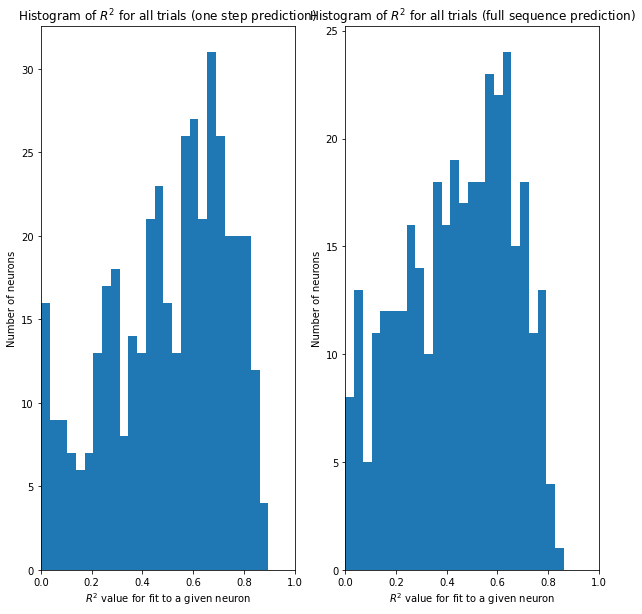

In [29]:
y_next_pred_lin = A_hat @ y_test_0.T + B_hat @ u_test_0.T + torch.outer(v_hat,torch.ones(y_test_0.shape[0]))
err_tot_lin = np.sum( (y_next_pred_lin.T.detach().numpy() - y_test_1.detach().numpy())**2, axis=0)
var = np.sum( (y_test_1.detach().numpy() - np.mean(y_test_1.detach().numpy(), axis=0))**2, axis=0)
r_squared_lin = 1 - err_tot_lin / var


state = y_test_0[0,:].clone()
states = np.zeros(y_test_0.shape)
states[0,:] = state

for t in range(y_test_0.shape[0]):
    state = A_hat @ state + B_hat @ u_test_0[0+t,:] + v_hat
    states[t,:] = state.clone().numpy()
    
err_tot_lin2 = np.sum( (states - y_test_1.detach().numpy())**2, axis=0)
r_squared_lin2 = 1 - err_tot_lin2 / var

plt.figure(figsize=(10,10))
# plt.subplot(1,2,1)
# plt.hist(r_squared,np.linspace(0,1,30))
# plt.title('Histogram of $R^2$ for all trials (sigmoid model)')
# plt.xlabel('$R^2$ value for fit to a given neuron')
# plt.ylabel('Number of neurons')
# plt.xlim([0,1])

plt.subplot(1,2,1)
plt.hist(r_squared_lin,np.linspace(0,1,30))
plt.title('Histogram of $R^2$ for all trials (one step prediction)')
plt.xlabel('$R^2$ value for fit to a given neuron')
plt.ylabel('Number of neurons')
plt.xlim([0,1])

plt.subplot(1,2,2)
plt.hist(r_squared_lin2,np.linspace(0,1,30))
plt.title('Histogram of $R^2$ for all trials (full sequence prediction)')
plt.xlabel('$R^2$ value for fit to a given neuron')
plt.ylabel('Number of neurons')
plt.xlim([0,1])

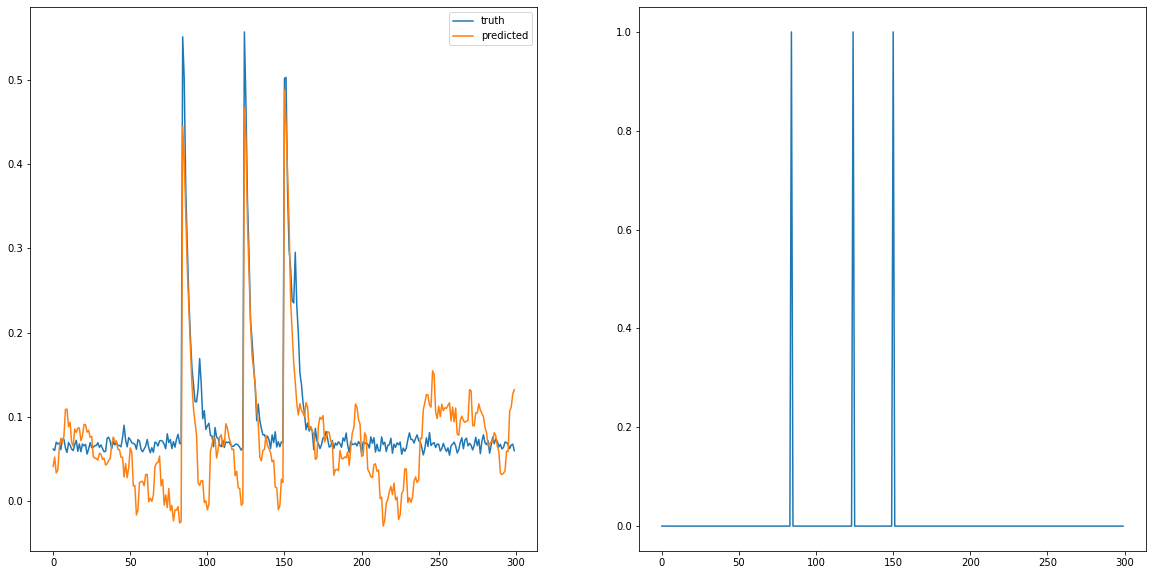

In [33]:
neuron = 41 # 41, 5, 1
T0 = 300 #720
T = 300
%matplotlib inline
#model.eval()
# y_test_0_interp = torch.tensor(y_test_full_interp[0:-1,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
# y_test_1_interp = torch.tensor(y_test_full_interp[1:,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
# u_test_0 = torch.tensor(u_test_full[0:-1,:].copy(), dtype=torch.float32)

state = y_test_0[T0,:].clone()
states = np.zeros((T,y_test_0.shape[1]))
states[0,:] = state

states_onestep = np.zeros((T,y_test_0.shape[1]))

for t in range(T):
#     state = model(state,u_test_0[T0+t,:]).detach()
#     states[t+1,:] = state.clone().numpy()
#     state2 = model(y_test_0_interp[T0+t,:],u_test_0[T0+t,:]).detach()
#     states_onestep[t+1,:] = state2.clone().numpy()
    
    state = A_hat @ state + B_hat @ u_test_0[T0+t,:] + v_hat
    states[t,:] = state.clone().numpy()
    state2 = A_hat @ y_test_0[T0+t,:] + B_hat @ u_test_0[T0+t,:] + v_hat
    states_onestep[t,:] = state2.clone().numpy()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(y_test_1[T0:T0+T,neuron].detach().numpy(),label='truth')
plt.plot(states[:,neuron],label='predicted')
#plt.plot(states_onestep[T0:T0+T,neuron],label='predicted (one step)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(u_test_0[T0:T0+T,neuron].detach().numpy(),label='input')
plt.show()

19.267553 31.129934
0.9510058


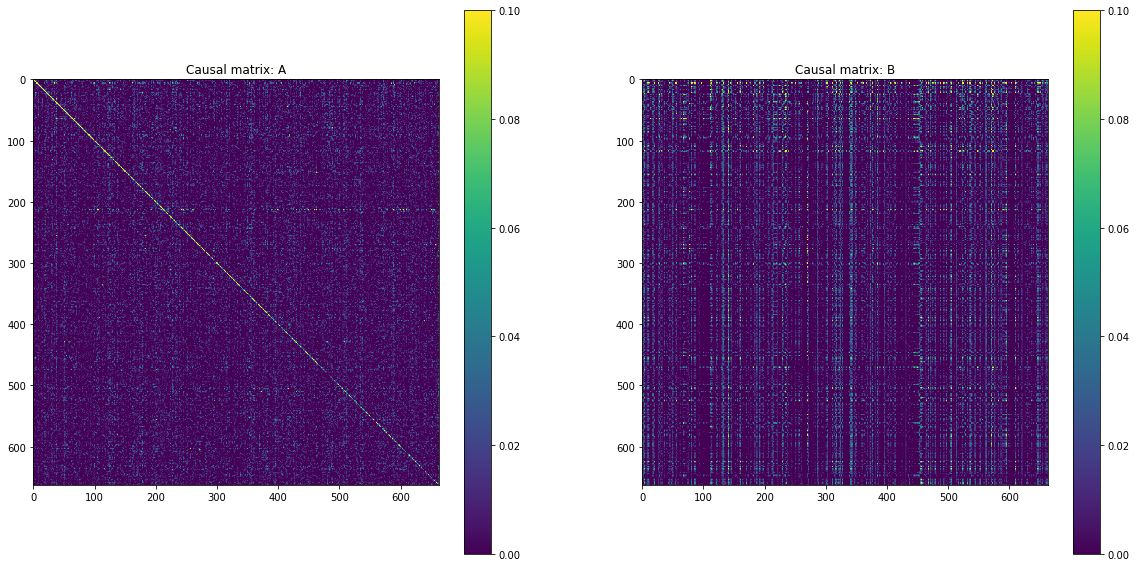

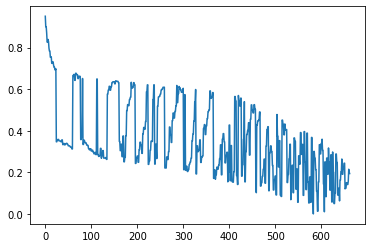

In [40]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(A_hat, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: A')

plt.subplot(1,2,2)
plt.imshow(B_hat, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: B')

print(np.linalg.norm(A_hat),np.linalg.norm(B_hat))
e,_ = np.linalg.eig(A_hat)
print(np.max(np.abs(e)))
plt.figure()
plt.plot(np.abs(e))

In [31]:
import matplotlib.animation as animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

x1 = data['x1']
x2 = data['x2']
o1 = data['o1']
o2 = data['o2']
group_ids = data['group_ids']
strial_ids = 2
stim_group_id = group_ids[strial_ids]

T0 = 0
T = y_test_0.shape[0]
state = y_test_0[T0,:].clone()
states = np.zeros((T,y_test_0.shape[1]))
states[0,:] = state

states_onestep = np.zeros((T,y_test_0.shape[1]))

for t in range(T):
    state = A_hat @ state + B_hat @ u_test_0[T0+t,:] + v_hat
    states[t,:] = state.clone().numpy()
    state2 = A_hat @ y_test_0[T0+t,:] + B_hat @ u_test_0[T0+t,:] + v_hat
    states_onestep[t,:] = state2.clone().numpy()
    
    
for t in range(T):
    fig, ax = plt.subplots()
    active_x1 = []
    active_x2 = []
    for i in range(u_test_0.shape[1]):
        if u_test_0[t,i] > 0:
            active_x1.append(x1[i])
            active_x2.append(x2[i])
    im = plt.subplot(1,2,1)
    im = plt.scatter(x1, x2, s = 30, marker='o', c=states[t,:], cmap='RdPu')
    plt.scatter(active_x1, active_x2, marker='o', s = 70, alpha =1, color = 'green',facecolors='none')
    plt.title('Predicted')
    plt.subplot(1,2,2)
    plt.scatter(x1, x2, s = 30, marker='o', c=y_test_1[t,:], cmap='RdPu')
    plt.scatter(active_x1, active_x2, marker='o', s = 70, alpha =1, color = 'green',facecolors='none')
    plt.title('Truth')
    plt.savefig('./im/im' + str(t) + '.png')
    plt.close()

print('done')

done


(4612, 663)


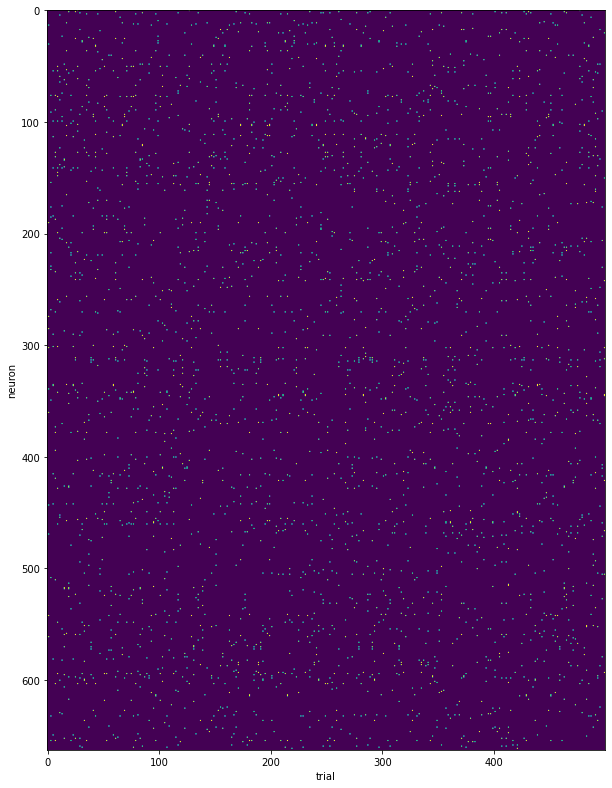

137
0


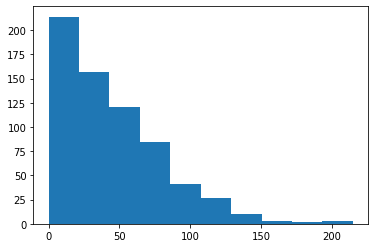

In [60]:
print(u_sub.shape)
plt.figure(figsize=(10,20))
plt.imshow(u_sub[0:500,:].T)
plt.ylabel('neuron')
plt.xlabel('trial')
plt.show()
total_excited1 = np.sum(u_sub[:,:],axis=0)
total_excited2 = np.sum(u_sub[500:,:],axis=0)
print(np.sum(total_excited1==0))
print(np.sum(np.logical_and(total_excited1>0,total_excited2==0)))
plt.hist(total_excited1)
plt.show()

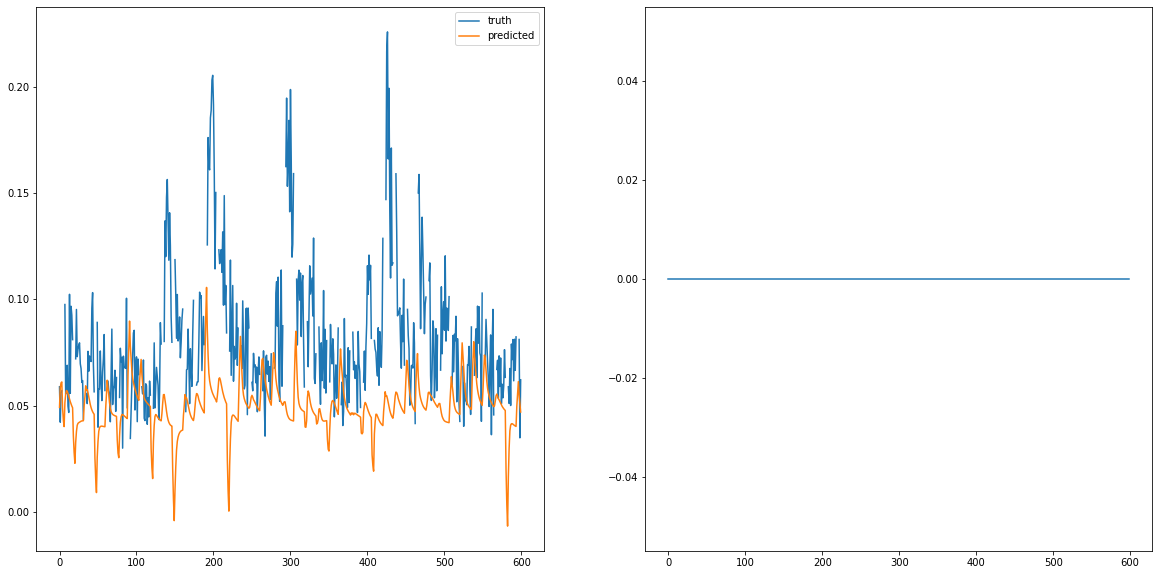

In [10]:
neuron = 21 # 41, 5, 1
T0 = 0 #720
T = 600
%matplotlib inline
#model.eval()
# y_test_0_interp = torch.tensor(y_test_full_interp[0:-1,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
# y_test_1_interp = torch.tensor(y_test_full_interp[1:,:].copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
# u_test_0 = torch.tensor(u_test_full[0:-1,:].copy(), dtype=torch.float32)

u_entire = torch.tensor(u_session.copy(), dtype=torch.float32)
y_entire = torch.tensor(y_session.copy(), dtype=torch.float32) / 1000

state = y_entire[T0,:].clone()
states = np.zeros((T,y_session.shape[1]))
states[0,:] = state

states_onestep = np.zeros((T,y_session.shape[1]))

for t in range(T):
    state = A_hat @ state + B_hat @ u_entire[T0+t,:] + v_hat
    states[t,:] = state.clone().numpy()
#     state2 = A_hat @ y_test_0[T0+t,:] + B_hat @ u_entire[T0+t,:] + v_hat
#     states_onestep[t,:] = state2.clone().numpy()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(y_entire[T0:T0+T,neuron].detach().numpy(),label='truth')
plt.plot(states[:,neuron],label='predicted')
#plt.plot(states_onestep[T0:T0+T,neuron],label='predicted (one step)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(u_entire[T0:T0+T,neuron].detach().numpy(),label='input')
plt.show()